In [1]:
import os
import numpy as np
import pandas as pd
import functions as F
import nlp_functions as NF
from importlib import reload
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer

from constants import DATA_DIR, RNG

In [2]:
# Retrieve preprocessed filament products dataframe, if available
# if os.path.exists(os.path.join(F.DATA_DIR, 'filament_prods.par')):
#     print('Reading pre-processed filament products file...')
#     filament_products = pd.read_parquet(os.path.join(F.DATA_DIR, 'filament_prods.par'))
# else:
#     print('Pre-processing filament products data...')
#     products = F.read_products_file('meta_Industrial_and_Scientific.jsonl')
#     filament_products = F.get_filament_products(products)
#     filament_products['relevant'] = np.nan
#     filament_products['topic'] = np.nan
    
#     print('Saving processed filament products data...')
#     filament_products.to_parquet(os.path.join(F.DATA_DIR, 'filament_prods.par'))
# print('Done')

In [46]:
filament_products = pd.read_parquet(os.path.join(F.DATA_DIR, 'fil_products_5rev.par'))
filament_products['relevant'] = np.nan
filament_products['topic'] = np.nan

In [ ]:
# manual_idxs = RNG.uniform(0, 1, len(filament_products))<0.2
# manual_subset = filament_products.loc[manual_idxs]
# withheld_subset = filament_products.loc[~manual_idxs]

In [51]:
subfolder = ''

In [55]:
manual_subset = pd.read_parquet(os.path.join(F.DATA_DIR, 'partial_labeled_010.par'))
manual_idxs = filament_products.index.isin(manual_subset.index)
manual_subset['relevant'] = np.nan

In [56]:
print(filament_products.shape, manual_subset.shape) #, withheld_subset.shape)

(2782, 14) (536, 14)


In [57]:
embedding_model = SentenceTransformer('all-MiniLM-L12-v2')
title_embeddings = embedding_model.encode(filament_products['title'].values, convert_to_tensor=False)

In [58]:
def update_clustering(df, topic_model, NB=None, cluster_size=20, subset=None):
    unknown = df['relevant'].isna()

    if subset is None:
        embeddings = title_embeddings
    else:
        embeddings = title_embeddings[subset]

    if NB is None:
        NB = NF.BernoulliNB_Clusterer(~unknown.values, df.loc[~unknown, 'relevant'], cluster_size, verbose=1)
        topics = NB.fit(embeddings)
    else:
        NB.cluster_size = cluster_size
        topics = NB.update_fit(~unknown.values, df.loc[~unknown, 'relevant'])
    df['topic'] = topics

    topic_model.verbose = False # Hide warning
    topic_model.update_topics(df['title'], topics=topics, embeddings=embeddings)
    topic_model.verbose = True
    centroids = topic_model.topic_embeddings_
    ordered_topics = NF.plot_generated_topics(df, centroids)
    return ordered_topics, NB

In [18]:
reload(NF);

In [59]:
centroids, topic_model = NF.gen_topics(manual_subset, 5, return_model=True, embeddings=title_embeddings[manual_idxs])

2025-03-31 00:30:57,862 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-31 00:30:58,600 - BERTopic - Dimensionality - Completed ✓
2025-03-31 00:30:58,601 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-31 00:30:58,616 - BERTopic - Cluster - Completed ✓
2025-03-31 00:30:58,618 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-31 00:30:58,647 - BERTopic - Representation - Completed ✓


In [60]:
topic_model.visualize_topics()

In [32]:
reload(NF);

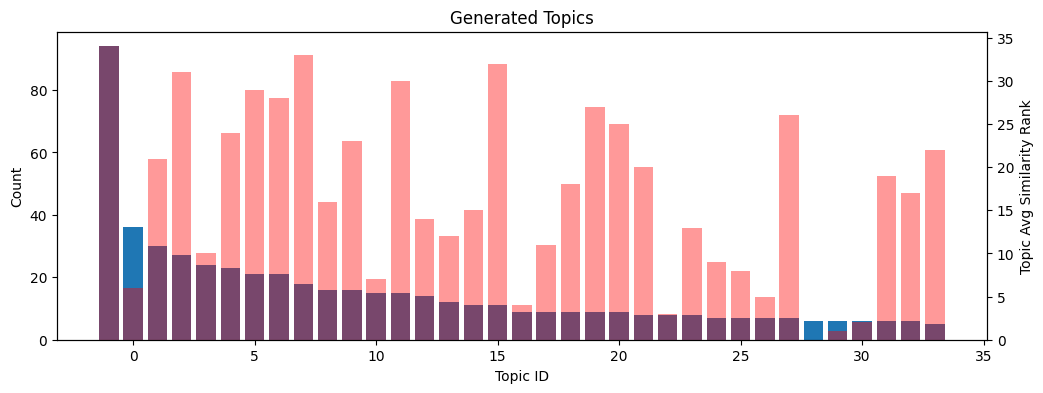

In [63]:
ordered_topics = NF.plot_generated_topics(manual_subset, centroids)

In [64]:
NF.manual_inspect(manual_subset, None, None, order=ordered_topics)

In [ ]:
# manual_subset.to_parquet(os.path.join(DATA_DIR, subfolder, 'partial_labeled_010.par'))

2025-03-31 00:32:52,058 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Cluster Sizes:
True: sub-clusters: 11, items: 312
False: sub-clusters: 3, items: 64


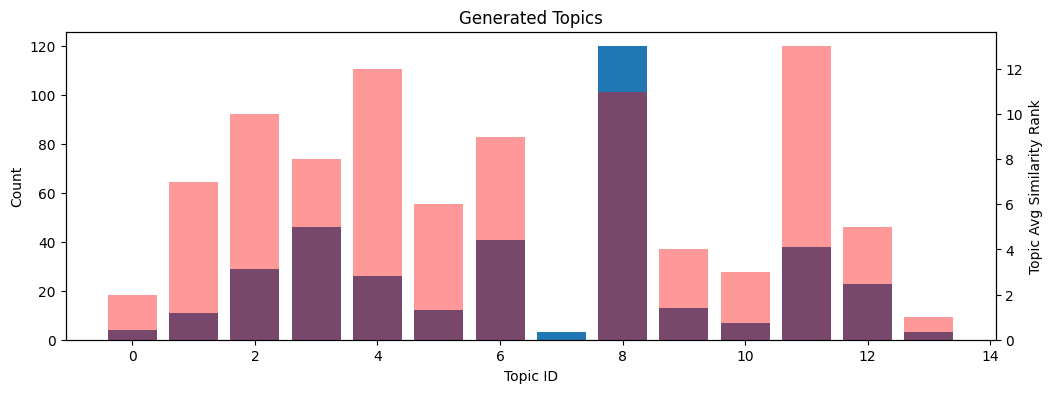

In [66]:
manual_subset_copy = manual_subset.copy(deep=True)
ordered_topics, NB = update_clustering(manual_subset_copy, topic_model, cluster_size=30, subset=manual_idxs)
topic_model.visualize_topics()

In [14]:
NF.manual_inspect(manual_subset_copy, None, None, order=ordered_topics, target_cluster_size=10)

In [15]:
manual_subset_copy.to_parquet(os.path.join(DATA_DIR, subfolder, 'partial_labeled_020.par'))

In [16]:
NF.print_cat_statistics(manual_subset_copy)

nan: 473 (80.3%)
False: 67 (11.4%)
True: 49 (8.3%)


2025-03-31 00:06:16,871 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Cluster Sizes:
True: sub-clusters: 21, items: 410
False: sub-clusters: 4, items: 63


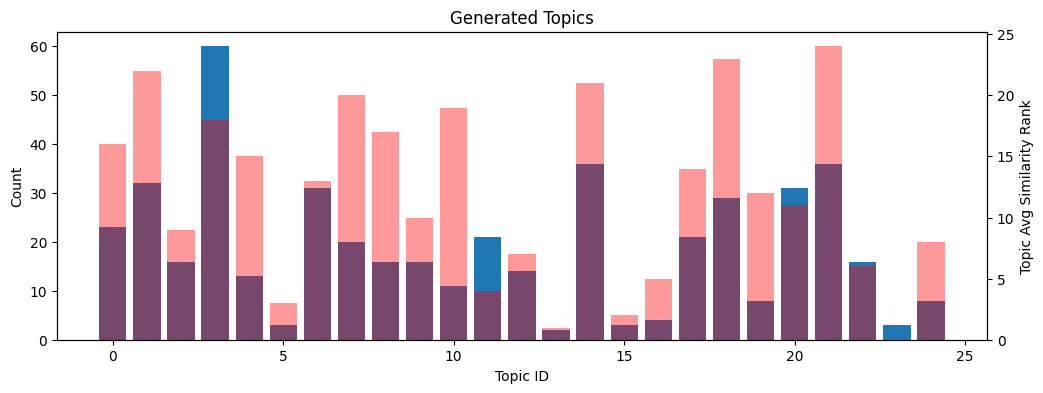

In [17]:
manual_subset_copy2 = manual_subset_copy.copy(deep=True)
ordered_topics, NB = update_clustering(manual_subset_copy2, topic_model, NB, subset=manual_idxs)
topic_model.visualize_topics()

In [18]:
NF.manual_inspect(manual_subset_copy2, None, None, order=ordered_topics, target_cluster_size=10)

In [19]:
manual_subset_copy2.to_parquet(os.path.join(DATA_DIR, subfolder, 'partial_labeled_030.par'))

2025-03-31 00:08:30,878 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Cluster Sizes:
True: sub-clusters: 20, items: 385
False: sub-clusters: 2, items: 25


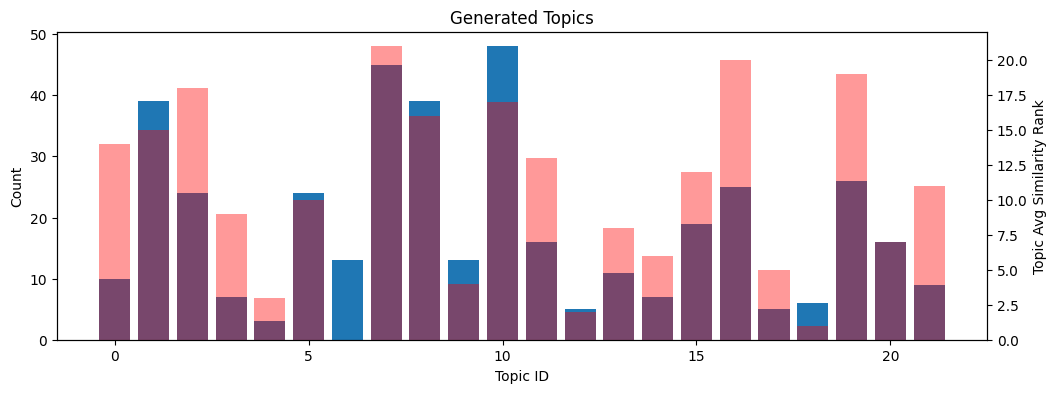

In [20]:
manual_subset_copy3 = manual_subset_copy2.copy(deep=True)
ordered_topics, NB = update_clustering(manual_subset_copy3, topic_model, NB, subset=manual_idxs)
topic_model.visualize_topics()

In [21]:
NF.manual_inspect(manual_subset_copy3, None, None, order=ordered_topics, target_cluster_size=10)

In [22]:
manual_subset_copy3.to_parquet(os.path.join(DATA_DIR, subfolder, 'partial_labeled_040.par'))

2025-03-31 00:09:24,188 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Cluster Sizes:
True: sub-clusters: 17, items: 336
False: sub-clusters: 2, items: 22


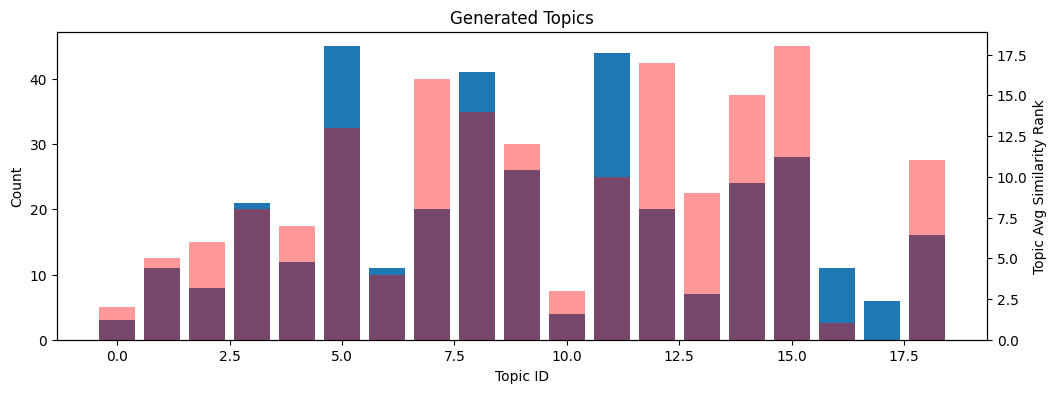

In [23]:
manual_subset_copy4 = manual_subset_copy3.copy(deep=True)
ordered_topics, NB = update_clustering(manual_subset_copy4, topic_model, NB, subset=manual_idxs)
topic_model.visualize_topics()

In [24]:
NF.manual_inspect(manual_subset_copy4, None, None, order=ordered_topics, target_cluster_size=10) # ordered_topics

In [25]:
manual_subset_copy4.to_parquet(os.path.join(DATA_DIR, subfolder, 'partial_labeled_050.par'))

2025-03-31 00:10:36,137 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Cluster Sizes:
True: sub-clusters: 14, items: 279
False: sub-clusters: 2, items: 18


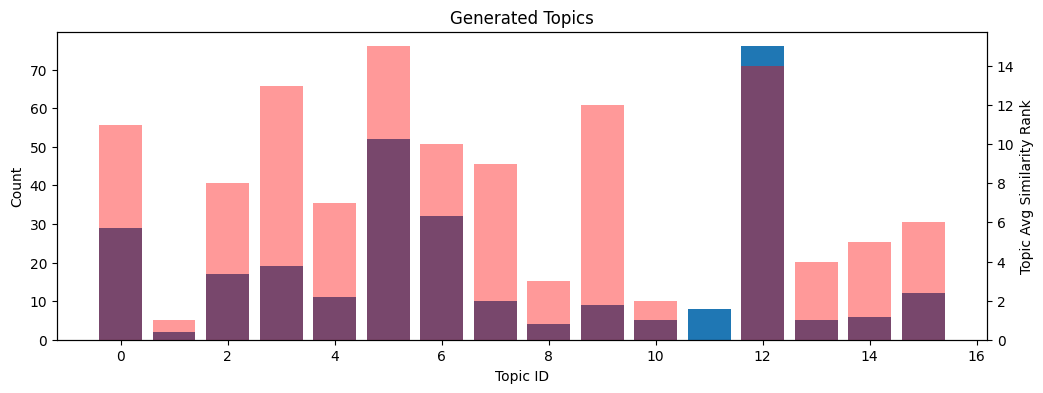

In [26]:
manual_subset_copy5 = manual_subset_copy4.copy(deep=True)
ordered_topics, NB = update_clustering(manual_subset_copy5, topic_model, NB, subset=manual_idxs)
topic_model.visualize_topics()

In [27]:
NF.manual_inspect(manual_subset_copy5, None, None, order=ordered_topics, target_cluster_size=10) #ordered_topics

In [28]:
manual_subset_copy5.to_parquet(os.path.join(DATA_DIR, subfolder, 'partial_labeled_060.par'))

2025-03-31 00:12:22,059 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Cluster Sizes:
True: sub-clusters: 11, items: 217
False: sub-clusters: 2, items: 17


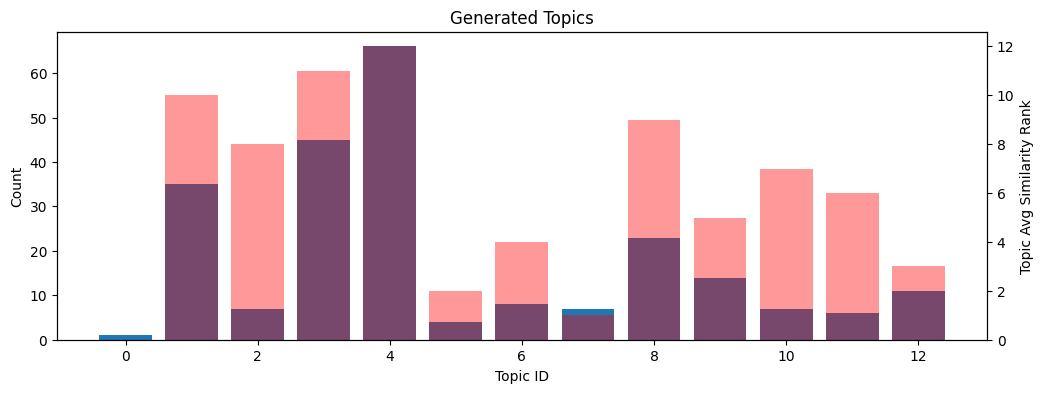

In [29]:
manual_subset_copy6 = manual_subset_copy5.copy(deep=True)
ordered_topics, NB = update_clustering(manual_subset_copy6, topic_model, NB, subset=manual_idxs)
topic_model.visualize_topics()

In [30]:
NF.manual_inspect(manual_subset_copy6, None, None, order=ordered_topics, target_cluster_size=10) #ordered_topics

In [31]:
manual_subset_copy6.to_parquet(os.path.join(DATA_DIR, subfolder, 'partial_labeled_070.par'))

2025-03-31 00:18:38,422 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Cluster Sizes:
True: sub-clusters: 25, items: 123
False: sub-clusters: 3, items: 15


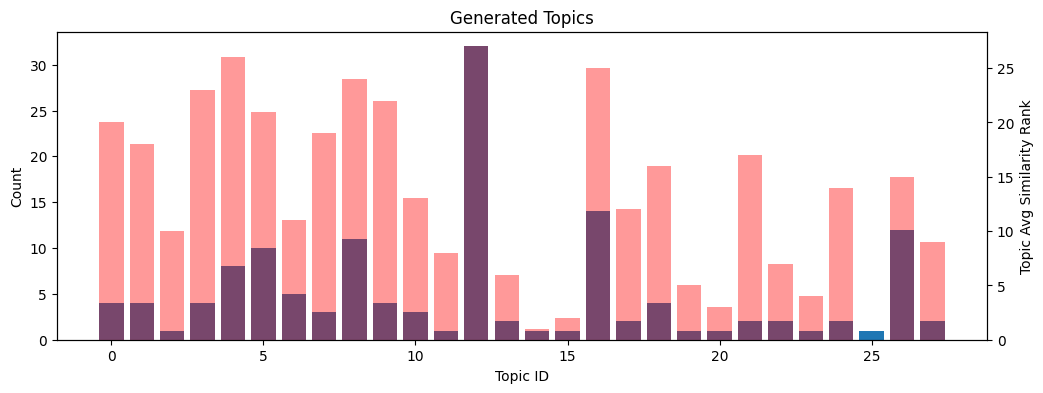

In [ ]:
manual_subset_copy7 = manual_subset_copy6.copy(deep=True)
ordered_topics, NB = update_clustering(manual_subset_copy7, topic_model, NB, subset=manual_idxs, cluster_size=5)
topic_model.visualize_topics()

In [37]:
NF.manual_inspect(manual_subset_copy7, None, None, order=ordered_topics, target_cluster_size=10) # ordered_topics

In [38]:
manual_subset_copy7.to_parquet(os.path.join(DATA_DIR, subfolder, 'partial_labeled_080.par'))

In [67]:
manual_subset_copy8 = pd.read_parquet(os.path.join(DATA_DIR, subfolder, 'partial_labeled_080.par'))

2025-03-31 00:34:54,357 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Cluster Sizes:
True: sub-clusters: 11, items: 54
False: sub-clusters: 2, items: 6


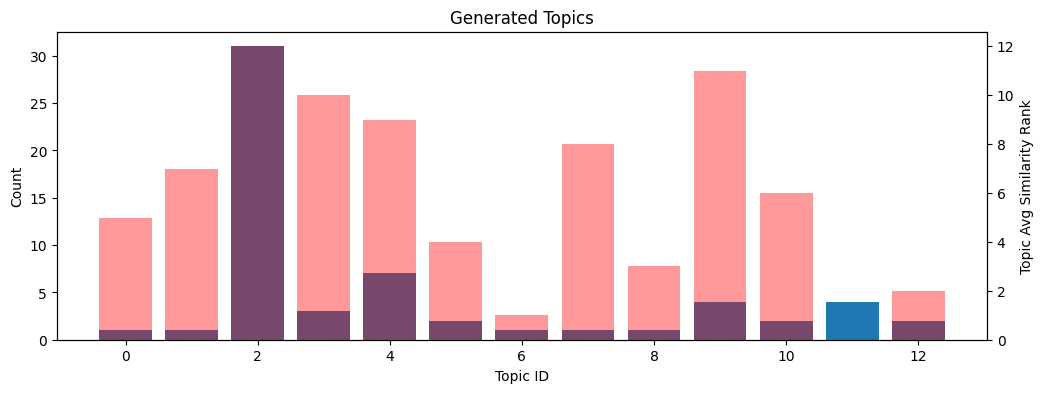

In [70]:
# manual_subset_copy8 = manual_subset_copy7.copy(deep=True)
ordered_topics, NB = update_clustering(manual_subset_copy8, topic_model, NB, subset=manual_idxs, cluster_size=5)
topic_model.visualize_topics()

In [71]:
NF.manual_inspect(manual_subset_copy8, None, None, order=ordered_topics, target_cluster_size=10) #ordered_topics

In [72]:
manual_subset_copy8.to_parquet(os.path.join(DATA_DIR, subfolder, 'partial_labeled_090.par'))

In [73]:
manual_subset_copy9 = manual_subset_copy8.copy(deep=True)
NF.manual_individual_review(manual_subset_copy9)

In [75]:
manual_subset_copy9.to_parquet(os.path.join(DATA_DIR, subfolder, 'partial_labeled_100.par'))

In [74]:
NF.print_cat_statistics(manual_subset_copy9)

True: 450 (84.0%)
False: 86 (16.0%)
